# [Flight delays](https://www.kaggle.com/c/flight-delays-spring-2018/overview)
Kaggle InClass competiton by [mlcourse.ai](mlcourse.ai). The task is to predict whether a flight will be delayed for more than 15 minutes

## Initialization

### Perform dataset preparing

In [2]:
%%capture output  
# pip install nbformat
# execute `output.show()` to show output figures and text (if they are)
%run ./2018-12-12-armavox-prepare-dataset.ipynb

### Init required  modules

__Notebook environment__

In [1]:
# pip install watermark
%load_ext watermark
%watermark -v -m -r -b -g -p numpy,pandas,sklearn,matplotlib,statsmodels,xgboost,catboost

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
matplotlib 2.2.2
statsmodels 0.9.0
xgboost 0.81
catboost 0.11.2

compiler   : GCC 7.3.0
system     : Linux
release    : 4.14.77-70.59.amzn1.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 685ac00570e3322c446306e2ad82609f344c94a9
Git repo   : https://github.com/armavox/flight-delays-fall-2018.git
Git branch : master


In [2]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.stats.weightstats as wsts
import scipy.stats as stats
from scipy.sparse import hstack, csr_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['patch.force_edgecolor'] = True

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### IMPORT DATA

In [3]:
train = pd.read_csv('../data/train.csv', index_col='idx')
train.head(3)

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend
idx,,,,,,,,,,
0,8,21,7,AA,ATL,DFW,732.0,19,34,1
1,4,20,3,US,PIT,MCO,834.0,15,48,0
2,9,2,5,XE,RDU,CLE,416.0,14,22,0


In [4]:
test = pd.read_csv('../data/test.csv', index_col='idx')
test.head(3)

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend
idx,,,,,,,,,,
0,7,25,3,YV,MRY,PHX,598.0,6,15,0
1,4,17,2,WN,LAS,HOU,1235.0,7,39,0
2,12,2,7,MQ,GSP,ORD,577.0,6,51,1


In [5]:
target = pd.read_csv('../data/target.csv', index_col='idx')
target.head(3)

,dep_delayed_15min
idx,
0,0
1,0
2,0


__Origin_Dest interaction: ``Route`` feature__

In [6]:
train['Route'] = train['Origin'] + '_' + train['Dest']
test['Route'] = test['Origin'] + '_' + test['Dest']

### FEATURES CONVERSION

In [7]:
train.head(1)

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend,Route
idx,,,,,,,,,,,
0,8,21,7,AA,ATL,DFW,732.0,19,34,1,ATL_DFW


In [8]:
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')

In [9]:
X_month_train = ohe.fit_transform(train.Month.values.reshape(-1, 1))
X_month_test = ohe.transform(test.Month.values.reshape(-1, 1))

In [10]:
X_dom_train = ohe.fit_transform(train.DayofMonth.values.reshape(-1, 1))
X_dom_test = ohe.transform(test.DayofMonth.values.reshape(-1, 1))

In [11]:
X_dow_train = ohe.fit_transform(train.DayOfWeek.values.reshape(-1, 1))
X_dow_test = ohe.transform(test.DayOfWeek.values.reshape(-1, 1))

In [12]:
X_hour_train = ohe.fit_transform(train.Hour.values.reshape(-1, 1))
X_hour_test = ohe.transform(test.Hour.values.reshape(-1, 1))

In [13]:
X_minute_train = ohe.fit_transform(train.Minute.values.reshape(-1, 1))
X_minute_test = ohe.transform(test.Minute.values.reshape(-1, 1))

In [14]:
X_isweekend_train = train.IsWeekend.values.reshape(-1, 1)
X_isweekend_test = test.IsWeekend.values.reshape(-1, 1)

In [15]:
X_carrier_train = ohe.fit_transform(train.UniqueCarrier.values.reshape(-1, 1))
X_carrier_test = ohe.transform(test.UniqueCarrier.values.reshape(-1, 1))

In [16]:
X_origin_train = ohe.fit_transform(train.Origin.values.reshape(-1, 1))
X_origin_test = ohe.transform(test.Origin.values.reshape(-1, 1))

In [17]:
X_dest_train = ohe.fit_transform(train.Dest.values.reshape(-1, 1))
X_dest_test = ohe.transform(test.Dest.values.reshape(-1, 1))

In [18]:
X_route_train = ohe.fit_transform(train.Route.values.reshape(-1, 1))
X_route_test = ohe.fit_transform(test.Route.values.reshape(-1, 1))

### SELECT FEATURES

In [ ]:
def simple_xgb_cv(X, y, n_estimators=27, max_depth=5, seed=42,
                   train_size=0.7):
    """Get ROC-AUC score for simple XGBoost classifier
    """
    skf = StratifiedKFold(n_splits=5, random_state=seed)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=train_size, random_state=seed)

    xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                        random_state=seed, n_jobs=-1).fit(X_train, y_train)
    
    roc_auc = roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1],
                            average='samples')
    
    cv_score = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', 
                               cv=skf, n_jobs=-1)
    return round(roc_auc, 5), round(cv_score.mean(), 5)

In [107]:
%%time
features = {'X_month_train': X_month_train, 
            'X_dom_train': X_dom_train, 
            'X_dow_train': X_dow_train, 
            'X_hour_train': X_hour_train, 
            'X_minute_train': X_minute_train,
            'X_isweekend_train': X_isweekend_train,
            'X_carrier_train': X_carrier_train,
            'X_origin_train': X_origin_train,
            'X_dest_train': X_dest_train,
            'X_route_train': X_route_train}

def select_best_feature_comb(features_dict):
    from scipy.sparse import hstack, csr_matrix, isspmatrix_csr
    
    results_dict = {}
    for l in range(1, len(features)+1):

        list_of_keys = [list(comb) for comb in 
                        itertools.combinations(features.keys(), l)]
        list_of_combs = [list(comb) for comb in 
                         itertools.combinations(features.values(), l)]

        for keys, comb in zip(list_of_keys, list_of_combs):
            print('Train on:', keys)
            
            is_csr = [isspmatrix_csr(x) for x in comb]
            if any(is_csr):
                X_con = hstack(comb, format='csr')
            else:
                comb[0] = csr_matrix(comb[0])
                X_con = hstack(comb, format='csr')
                
            result = simple_xgb_cv(X_con, y)
            results_dict[', '.join(keys)] = result
            print(f'CV: {result[1]}, OOF: {result[0]}', '\n')
            
    return results_dict

select_best_feature_comb(features)

Train on: ['X_month_train']
CV: 0.55243, OOF: 0.5521 

Train on: ['X_dom_train']
CV: 0.52353, OOF: 0.52167 

Train on: ['X_dow_train']
CV: 0.53438, OOF: 0.53991 

Train on: ['X_hour_train']
CV: 0.68467, OOF: 0.68235 

Train on: ['X_minute_train']
CV: 0.52264, OOF: 0.52692 

Train on: ['X_isweekend_train']
CV: 0.50765, OOF: 0.51224 

Train on: ['X_carrier_train']
CV: 0.54553, OOF: 0.54288 

Train on: ['X_origin_train']
CV: 0.54804, OOF: 0.55324 

Train on: ['X_dest_train']
CV: 0.54306, OOF: 0.54792 

Train on: ['X_route_train']
CV: 0.5097, OOF: 0.50741 

Train on: ['X_month_train', 'X_dom_train']
CV: 0.57066, OOF: 0.5735 

Train on: ['X_month_train', 'X_dow_train']
CV: 0.56612, OOF: 0.57273 

Train on: ['X_month_train', 'X_hour_train']
CV: 0.68989, OOF: 0.68917 

Train on: ['X_month_train', 'X_minute_train']
CV: 0.5537, OOF: 0.55604 

Train on: ['X_month_train', 'X_isweekend_train']
CV: 0.55462, OOF: 0.55599 

Train on: ['X_month_train', 'X_carrier_train']
CV: 0.5734, OOF: 0.56957 

Tra

CV: 0.68427, OOF: 0.68263 

Train on: ['X_dom_train', 'X_minute_train', 'X_isweekend_train']
CV: 0.53193, OOF: 0.53579 

Train on: ['X_dom_train', 'X_minute_train', 'X_carrier_train']
CV: 0.55224, OOF: 0.55165 

Train on: ['X_dom_train', 'X_minute_train', 'X_origin_train']
CV: 0.55583, OOF: 0.55908 

Train on: ['X_dom_train', 'X_minute_train', 'X_dest_train']
CV: 0.54802, OOF: 0.55253 

Train on: ['X_dom_train', 'X_minute_train', 'X_route_train']
CV: 0.52819, OOF: 0.53182 

Train on: ['X_dom_train', 'X_isweekend_train', 'X_carrier_train']
CV: 0.54898, OOF: 0.55237 

Train on: ['X_dom_train', 'X_isweekend_train', 'X_origin_train']
CV: 0.55625, OOF: 0.55808 

Train on: ['X_dom_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.55016, OOF: 0.55029 

Train on: ['X_dom_train', 'X_isweekend_train', 'X_route_train']
CV: 0.5305, OOF: 0.53136 

Train on: ['X_dom_train', 'X_carrier_train', 'X_origin_train']
CV: 0.56726, OOF: 0.57053 

Train on: ['X_dom_train', 'X_carrier_train', 'X_dest_train']


CV: 0.5769, OOF: 0.58115 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_route_train']
CV: 0.56683, OOF: 0.56899 

Train on: ['X_month_train', 'X_dom_train', 'X_isweekend_train', 'X_carrier_train']
CV: 0.57824, OOF: 0.57834 

Train on: ['X_month_train', 'X_dom_train', 'X_isweekend_train', 'X_origin_train']
CV: 0.57902, OOF: 0.58144 

Train on: ['X_month_train', 'X_dom_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.57678, OOF: 0.58175 

Train on: ['X_month_train', 'X_dom_train', 'X_isweekend_train', 'X_route_train']
CV: 0.567, OOF: 0.56867 

Train on: ['X_month_train', 'X_dom_train', 'X_carrier_train', 'X_origin_train']
CV: 0.588, OOF: 0.59089 

Train on: ['X_month_train', 'X_dom_train', 'X_carrier_train', 'X_dest_train']
CV: 0.58601, OOF: 0.58416 

Train on: ['X_month_train', 'X_dom_train', 'X_carrier_train', 'X_route_train']
CV: 0.57693, OOF: 0.57264 

Train on: ['X_month_train', 'X_dom_train', 'X_origin_train', 'X_dest_train']
CV: 0.58677, OOF: 0.59226 

Train o

CV: 0.56252, OOF: 0.57023 

Train on: ['X_dom_train', 'X_dow_train', 'X_minute_train', 'X_route_train']
CV: 0.55069, OOF: 0.55729 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train']
CV: 0.56592, OOF: 0.5663 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_origin_train']
CV: 0.56766, OOF: 0.57229 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.56267, OOF: 0.57191 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_route_train']
CV: 0.55029, OOF: 0.55947 

Train on: ['X_dom_train', 'X_dow_train', 'X_carrier_train', 'X_origin_train']
CV: 0.57667, OOF: 0.58286 

Train on: ['X_dom_train', 'X_dow_train', 'X_carrier_train', 'X_dest_train']
CV: 0.5765, OOF: 0.57552 

Train on: ['X_dom_train', 'X_dow_train', 'X_carrier_train', 'X_route_train']
CV: 0.56479, OOF: 0.56651 

Train on: ['X_dom_train', 'X_dow_train', 'X_origin_train', 'X_dest_train']
CV: 0.57713, OOF: 0.58531 

Train on: ['X_dom_trai

CV: 0.5595, OOF: 0.56325 

Train on: ['X_dow_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train']
CV: 0.58491, OOF: 0.58941 

Train on: ['X_dow_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.57266, OOF: 0.57813 

Train on: ['X_dow_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.57376, OOF: 0.57365 

Train on: ['X_dow_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.57442, OOF: 0.58031 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train']
CV: 0.68819, OOF: 0.68618 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train']
CV: 0.68684, OOF: 0.68481 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.68597, OOF: 0.6848 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_route_train']
CV: 0.68442, OOF: 0.68239 

Train on: ['X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69015, OOF: 0.

CV: 0.6955, OOF: 0.69451 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_carrier_train', 'X_route_train']
CV: 0.69422, OOF: 0.69247 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_origin_train', 'X_dest_train']
CV: 0.6933, OOF: 0.6921 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_origin_train', 'X_route_train']
CV: 0.69293, OOF: 0.69178 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_dest_train', 'X_route_train']
CV: 0.69214, OOF: 0.69205 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train']
CV: 0.58088, OOF: 0.58152 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train']
CV: 0.57857, OOF: 0.58149 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.57671, OOF: 0.5824 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_isweekend_train', 'X_route_train']
CV: 0.56

CV: 0.69338, OOF: 0.69231 

Train on: ['X_month_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_dest_train']
CV: 0.69251, OOF: 0.69156 

Train on: ['X_month_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_route_train']
CV: 0.69227, OOF: 0.69083 

Train on: ['X_month_train', 'X_hour_train', 'X_minute_train', 'X_dest_train', 'X_route_train']
CV: 0.6911, OOF: 0.69097 

Train on: ['X_month_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69416, OOF: 0.69448 

Train on: ['X_month_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train']
CV: 0.69514, OOF: 0.69386 

Train on: ['X_month_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_route_train']
CV: 0.69384, OOF: 0.69256 

Train on: ['X_month_train', 'X_hour_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train']
CV: 0.69306, OOF: 0.6914 

Train on: ['X_month_train', 'X_hour_train', 'X_isweekend_train', 'X_origin_train', 'X_ro

CV: 0.68627, OOF: 0.68483 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_route_train']
CV: 0.68425, OOF: 0.68267 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train']
CV: 0.6893, OOF: 0.68912 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_dest_train']
CV: 0.68901, OOF: 0.68827 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_route_train']
CV: 0.68809, OOF: 0.68604 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_dest_train']
CV: 0.68755, OOF: 0.68521 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_route_train']
CV: 0.68702, OOF: 0.68458 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_dest_train', 'X_route_train']
CV: 0.68619, OOF: 0.68451 

Train on: ['X_dom_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.688

CV: 0.57438, OOF: 0.57981 

Train on: ['X_dow_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.58501, OOF: 0.58992 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.68985, OOF: 0.68842 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train']
CV: 0.68912, OOF: 0.68782 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_route_train']
CV: 0.68789, OOF: 0.68595 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train']
CV: 0.68753, OOF: 0.68528 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train', 'X_route_train']
CV: 0.68692, OOF: 0.68444 

Train on: ['X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_dest_train', 'X_route_train']
CV: 0.68586, OOF: 0.68459 

Train on: ['X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_

CV: 0.69006, OOF: 0.69016 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69448, OOF: 0.69408 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_dest_train']
CV: 0.6947, OOF: 0.69476 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_route_train']
CV: 0.69432, OOF: 0.69047 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_dest_train']
CV: 0.69356, OOF: 0.69213 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_route_train']
CV: 0.69311, OOF: 0.69249 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_minute_train', 'X_dest_train', 'X_route_train']
CV: 0.6911, OOF: 0.69211 

Train on: ['X_month_train', 'X_dom_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69444, OOF:

CV: 0.59977, OOF: 0.60511 

Train on: ['X_month_train', 'X_dow_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.59382, OOF: 0.5981 

Train on: ['X_month_train', 'X_dow_train', 'X_minute_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.59288, OOF: 0.59386 

Train on: ['X_month_train', 'X_dow_train', 'X_minute_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.59102, OOF: 0.59483 

Train on: ['X_month_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train']
CV: 0.59951, OOF: 0.60337 

Train on: ['X_month_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.59359, OOF: 0.59795 

Train on: ['X_month_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.59226, OOF: 0.59242 

Train on: ['X_month_train', 'X_dow_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train', 'X_route_train']

CV: 0.5782, OOF: 0.57903 

Train on: ['X_dom_train', 'X_dow_train', 'X_minute_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.57616, OOF: 0.5848 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train']
CV: 0.58672, OOF: 0.59054 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.57588, OOF: 0.58262 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.57695, OOF: 0.57566 

Train on: ['X_dom_train', 'X_dow_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.57776, OOF: 0.58468 

Train on: ['X_dom_train', 'X_dow_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.58736, OOF: 0.59256 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.689

CV: 0.69369, OOF: 0.69318 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_dest_train']
CV: 0.69241, OOF: 0.69354 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_route_train']
CV: 0.69037, OOF: 0.68998 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69569, OOF: 0.69451 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_dest_train']
CV: 0.69512, OOF: 0.69637 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_route_train']
CV: 0.69429, OOF: 0.69257 

Train on: ['X_month_train', 'X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_origin_train', 'X_dest_train']
CV: 0.69383, OOF: 0.69228 

Train on: ['X_month_train', 'X_dom_

CV: 0.58744, OOF: 0.59288 

Train on: ['X_month_train', 'X_dom_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.5961, OOF: 0.59898 

Train on: ['X_month_train', 'X_dom_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.59505, OOF: 0.59971 

Train on: ['X_month_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train']
CV: 0.69481, OOF: 0.69394 

Train on: ['X_month_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train']
CV: 0.69578, OOF: 0.69385 

Train on: ['X_month_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_route_train']
CV: 0.69375, OOF: 0.69262 

Train on: ['X_month_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train']
CV: 0.69371, OOF: 0.6916 

Train o

CV: 0.69078, OOF: 0.68832 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.68938, OOF: 0.68797 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.68871, OOF: 0.68867 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.68755, OOF: 0.68529 

Train on: ['X_dom_train', 'X_hour_train', 'X_minute_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.69045, OOF: 0.68831 

Train on: ['X_dom_train', 'X_hour_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.69034, OOF: 0.68823 

Train on: ['X_dom_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.5825, OOF: 0.58633 

Train o

CV: 0.69574, OOF: 0.69457 

Train on: ['X_month_train', 'X_dow_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.59932, OOF: 0.60609 

Train on: ['X_month_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train', 'X_route_train']
CV: 0.69456, OOF: 0.69408 

Train on: ['X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_dest_train']
CV: 0.69423, OOF: 0.6952 

Train on: ['X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_origin_train', 'X_route_train']
CV: 0.69259, OOF: 0.69059 

Train on: ['X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isweekend_train', 'X_carrier_train', 'X_dest_train', 'X_route_train']
CV: 0.69162, OOF: 0.69342 

Train on: ['X_dom_train', 'X_dow_train', 'X_hour_train', 'X_minute_train', 'X_isw

### CONCATENATE DATA

In [ ]:
y = target.dep_delayed_15min.values
print("Classes in dataset:", np.unique(y)) 
print('Size:', y.shape)
print("positive objects:", y.sum())
balance_coef = np.sum(y==0) /  np.sum(y==1)

Classes in dataset: [0 1]
Size: (99994,)
positive objects: 19038


In [ ]:
# Best feature combination

X = np.hstack([
    X_month_train,
    X_dom_train,
    X_dow_train,
    X_hour_train,
    X_minute_train,
    X_isweekend_train,
    X_carrier_train,
#     X_origin_train
    X_dest_train,
#     X_route_train
])

X_test = np.hstack([
    X_month_test,
    X_dom_test,
    X_dow_test,
    X_hour_test,
    X_minute_test,
    X_isweekend_test,
    X_carrier_test,
#     X_origin_test,
    X_dest_test,
#     X_route_test
])

X.shape, X_test.shape, y.shape

((99994, 447), (100000, 447), (99994,))

## XGBoost TUNING

### Simple XGBoost

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.9, random_state=42)
skf = StratifiedKFold(n_splits=5, random_state=42)

In [ ]:
xgb = XGBClassifier(n_estimators=300, max_depth=3, random_state=42, n_jobs=-1)

In [ ]:
%%capture In24
%%time
xgb.fit(X_train, y_train)
print(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]))

In [ ]:
%%capture In25
_cv_score = cross_val_score(xgb, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)
_cv_score.mean(), _cv_score.std()

In [29]:
In25.show()

(0.7226337099989414, 0.004421514407358841)

### XGB CV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Iteration #1. Model complexity

In [33]:
_xgb_grid_params_iteration1 = {
    'colsample_bytree': np.linspace(0.4, 1, 5),
    'gamma': np.linspace(0.5, 1, 5),
    'max_depth': np.arange(1, 11),
    'min_child_weight': np.arange(1,11),
    'reg_alpha': np.logspace(-2, 2, 8),
    'reg_lambda': np.logspace(-2, 2, 8),
    'subsample': np.linspace(0.5, 1, 8)
}

In [ ]:
%%capture In28
%%time
xgb = XGBClassifier(n_estimators=30, 
                    scale_pos_weight=balance_coef,
                    random_state=42, n_jobs=-1)

xgb_search1 = RandomizedSearchCV(xgb, _xgb_grid_params_iteration1, 
                                 n_iter=1000, cv=skf, scoring='roc_auc', 
                                 random_state=42, n_jobs=-1, verbose=1)
xgb_search1.fit(X_train, y_train)

In [ ]:
%%capture In29
xgbest1 = xgb_search1.best_estimator_
xgb_best_complexity = xgb_search1.best_params_
xgb_search1.best_score_, xgb_search1.best_params_

In [ ]:
%%capture In30
print(f"""ROC-AUC on the validation data: 
{roc_auc_score(y_valid, xgbest1.predict_proba(X_valid)[:, 1]):.5f}""")

In [45]:
In29.show()

(0.7189629731115568,
 {'subsample': 0.7857142857142857,
  'reg_lambda': 7.196856730011514,
  'reg_alpha': 0.517947467923121,
  'min_child_weight': 6,
  'max_depth': 10,
  'gamma': 0.5,
  'colsample_bytree': 1.0})

In [44]:
In30.show()

ROC-AUC on the validation data: 
0.71813


In [49]:
import xgboost as xgb

#### Iteration #2. Model optimization

In [50]:
dtrain = xgb.DMatrix(X, y)

In [81]:
best_params = xgb_best_complexity
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 16
# best_params['silent'] = 1
best_params['eval_metric'] = 'auc'
best_params['eta'] = 0.05
best_params

{'subsample': 0.7857142857142857,
 'reg_lambda': 7.196856730011514,
 'reg_alpha': 0.517947467923121,
 'min_child_weight': 6,
 'max_depth': 10,
 'gamma': 0.5,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'nthread': 16,
 'silent': 1,
 'eval_metric': 'auc',
 'eta': 0.05}

In [75]:
%%time
xgb_cv = xgb.cv(best_params, dtrain, num_boost_round=500, metrics='auc',
                stratified=True, nfold=5, early_stopping_rounds=50, 
                verbose_eval=True, seed=42)

[0]	train-auc:0.661965+0.00170874	test-auc:0.661106+0.00573831
[1]	train-auc:0.666211+0.00321601	test-auc:0.66512+0.0072803
[2]	train-auc:0.668739+0.00615185	test-auc:0.667726+0.0100716
[3]	train-auc:0.669888+0.00532962	test-auc:0.668545+0.00914005
[4]	train-auc:0.671579+0.00504608	test-auc:0.670214+0.010174
[5]	train-auc:0.671613+0.00504469	test-auc:0.670383+0.0101719
[6]	train-auc:0.673289+0.00460631	test-auc:0.671945+0.00989601
[7]	train-auc:0.673378+0.00459601	test-auc:0.672011+0.00994917
[8]	train-auc:0.675173+0.00399697	test-auc:0.673561+0.00894783
[9]	train-auc:0.675125+0.00392005	test-auc:0.673474+0.00887046
[10]	train-auc:0.675207+0.00401769	test-auc:0.673573+0.00897744
[11]	train-auc:0.675334+0.0041099	test-auc:0.673676+0.00909633
[12]	train-auc:0.675284+0.00410831	test-auc:0.673655+0.00907242
[13]	train-auc:0.675429+0.00413749	test-auc:0.673829+0.00903435
[14]	train-auc:0.677075+0.00688867	test-auc:0.675268+0.0111192
[15]	train-auc:0.677123+0.00704944	test-auc:0.675251+0.011

[129]	train-auc:0.699082+0.00173075	test-auc:0.695651+0.00737615
[130]	train-auc:0.699071+0.00169863	test-auc:0.695646+0.00738709
[131]	train-auc:0.699069+0.00169042	test-auc:0.695636+0.00740336
[132]	train-auc:0.699073+0.00168944	test-auc:0.695623+0.00739666
[133]	train-auc:0.699115+0.00164294	test-auc:0.695708+0.00744914
[134]	train-auc:0.699285+0.00174452	test-auc:0.695837+0.00725572
[135]	train-auc:0.699286+0.00177548	test-auc:0.695821+0.00725789
[136]	train-auc:0.699337+0.0017128	test-auc:0.695871+0.0073098
[137]	train-auc:0.699352+0.00171435	test-auc:0.695878+0.00734373
[138]	train-auc:0.699382+0.00170838	test-auc:0.69591+0.00731125
[139]	train-auc:0.699412+0.00173868	test-auc:0.695898+0.00730984
[140]	train-auc:0.699533+0.00184239	test-auc:0.696024+0.00715237
[141]	train-auc:0.699534+0.0018291	test-auc:0.696025+0.00716497
[142]	train-auc:0.699553+0.00182882	test-auc:0.696034+0.00718615
[143]	train-auc:0.69962+0.00180514	test-auc:0.69608+0.00716274
[144]	train-auc:0.699762+0.0017

[257]	train-auc:0.70389+0.00181456	test-auc:0.699429+0.00710675
[258]	train-auc:0.703895+0.00182788	test-auc:0.699415+0.0071138
[259]	train-auc:0.703979+0.00179935	test-auc:0.699502+0.00712841
[260]	train-auc:0.704004+0.00180547	test-auc:0.699512+0.00710851
[261]	train-auc:0.704065+0.00174476	test-auc:0.699557+0.00714469
[262]	train-auc:0.704123+0.00180126	test-auc:0.699605+0.00710048
[263]	train-auc:0.704131+0.00183396	test-auc:0.699639+0.00710099
[264]	train-auc:0.704184+0.00180172	test-auc:0.699669+0.00710503
[265]	train-auc:0.704224+0.00180075	test-auc:0.69968+0.00707514
[266]	train-auc:0.704235+0.00180859	test-auc:0.699674+0.00707352
[267]	train-auc:0.704313+0.00174227	test-auc:0.699778+0.0070895
[268]	train-auc:0.704331+0.0017466	test-auc:0.699792+0.00710826
[269]	train-auc:0.704427+0.00173748	test-auc:0.699891+0.00709893
[270]	train-auc:0.704449+0.00173036	test-auc:0.699896+0.00712447
[271]	train-auc:0.704466+0.00173391	test-auc:0.699914+0.00712033
[272]	train-auc:0.704548+0.001

[384]	train-auc:0.708068+0.00158982	test-auc:0.702554+0.00711269
[385]	train-auc:0.708104+0.00160559	test-auc:0.702599+0.00712175
[386]	train-auc:0.708135+0.00159268	test-auc:0.702579+0.00711181
[387]	train-auc:0.708151+0.00159553	test-auc:0.702589+0.00710927
[388]	train-auc:0.708173+0.00163603	test-auc:0.702602+0.00708365
[389]	train-auc:0.708187+0.00164572	test-auc:0.702598+0.00709002
[390]	train-auc:0.7082+0.00165353	test-auc:0.702604+0.00707953
[391]	train-auc:0.708251+0.00166433	test-auc:0.702668+0.00711952
[392]	train-auc:0.70828+0.00166045	test-auc:0.702672+0.00712729
[393]	train-auc:0.708328+0.00167491	test-auc:0.702714+0.00712078
[394]	train-auc:0.708402+0.00167422	test-auc:0.702744+0.00714183
[395]	train-auc:0.708416+0.00165989	test-auc:0.702756+0.0071272
[396]	train-auc:0.708448+0.00164305	test-auc:0.702793+0.00714659
[397]	train-auc:0.708459+0.00164308	test-auc:0.7028+0.00716115
[398]	train-auc:0.708485+0.00162804	test-auc:0.702815+0.00717737
[399]	train-auc:0.708498+0.0016

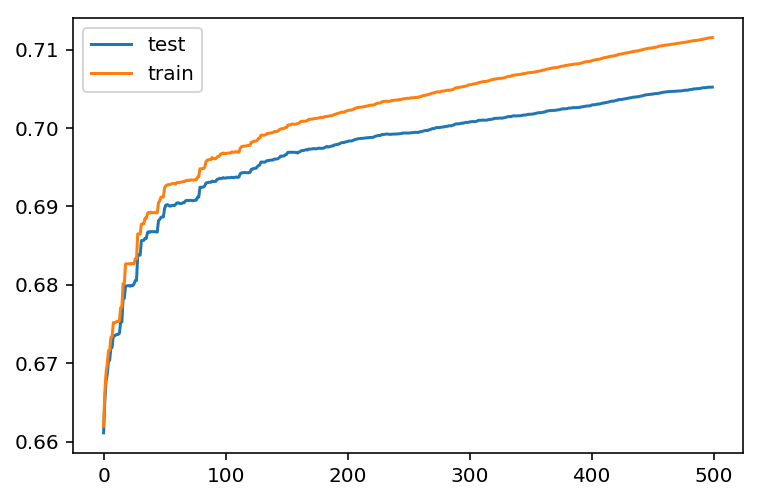

In [77]:
plt.plot(range(xgb_cv.shape[0]), xgb_cv['test-auc-mean'], label='test')
plt.plot(range(xgb_cv.shape[0]), xgb_cv['train-auc-mean'], label='train')
plt.legend();

In [ ]:
best_num_round = np.argmin(xgb_cv['test-auc-mean'])

#### hyperopt optimization

In [112]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.7, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((69995, 447), (29999, 447), (69995,), (29999,))

In [150]:
def score(params):
    print("Training with params:")
    print(params)
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid)
    params['max_depth'] = int(params['max_depth'])
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape(-1, 1)
    score = 1 - roc_auc_score(y_valid, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [151]:
def optimize(trials):
    space = {
             'num_round': 30,
             'learning_rate': 0.05,
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 8,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [152]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.6900000000000001, 'learning_rate': 0.05, 'max_depth': 6.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 30, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9500000000000001}
	Score 0.3136344696845841


Training with params:
{'colsample_bytree': 0.45, 'eval_metric': 'auc', 'gamma': 0.6900000000000001, 'learning_rate': 0.05, 'max_depth': 6.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 30, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9500000000000001}
	Score 0.3041572656925441


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.9400000000000001, 'learning_rate': 0.05, 'max_depth': 5.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_round': 30, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}
	Score 0.31311726001742124


Training with params:
{'colsample_bytree': 0.55, 'eval_metric': 'auc', 'gamma': 0.54, 'learning_rate': 0.0

{'colsample_bytree': 0.55,
 'gamma': 0.62,
 'max_depth': 12.0,
 'min_child_weight': 2.0,
 'subsample': 0.9500000000000001}

In [158]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eta']= 0.05
best_params['eval_metric']= 'auc'
best_params['objective']= 'binary:logistic'
best_params['nthread'] = 8
best_params['silent'] = 1
best_params

{'colsample_bytree': 0.55,
 'gamma': 0.62,
 'max_depth': 12,
 'min_child_weight': 2.0,
 'subsample': 0.9500000000000001,
 'eta': 0.05,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'nthread': 8,
 'silent': 1}

In [159]:
%%time
xgb_cv = xgb.cv(best_params, dtrain, num_boost_round=500, metrics='auc',
                stratified=True, nfold=5, early_stopping_rounds=50, 
                verbose_eval=True, seed=42)

[0]	train-auc:0.655216+0.00977376	test-auc:0.64193+0.00948103
[1]	train-auc:0.690345+0.0062928	test-auc:0.674904+0.00568614
[2]	train-auc:0.707298+0.00579971	test-auc:0.68894+0.00576778
[3]	train-auc:0.71444+0.00759625	test-auc:0.695074+0.00878652
[4]	train-auc:0.716725+0.00677172	test-auc:0.697351+0.00855053
[5]	train-auc:0.718752+0.00514152	test-auc:0.699236+0.00895918
[6]	train-auc:0.720635+0.00536761	test-auc:0.700435+0.00857353
[7]	train-auc:0.722431+0.00576879	test-auc:0.701193+0.00937264
[8]	train-auc:0.724338+0.00595833	test-auc:0.702748+0.00956342
[9]	train-auc:0.72716+0.00443228	test-auc:0.705522+0.00875893
[10]	train-auc:0.728171+0.00308921	test-auc:0.706285+0.00772662
[11]	train-auc:0.729171+0.00312113	test-auc:0.706967+0.00770112
[12]	train-auc:0.730422+0.00320177	test-auc:0.707831+0.00769461
[13]	train-auc:0.732175+0.0039027	test-auc:0.708859+0.00744695
[14]	train-auc:0.733741+0.00345093	test-auc:0.70996+0.00681024
[15]	train-auc:0.734358+0.00289816	test-auc:0.710115+0.00

[129]	train-auc:0.784925+0.00154997	test-auc:0.727383+0.00504899
[130]	train-auc:0.785359+0.00156091	test-auc:0.727535+0.00507021
[131]	train-auc:0.785699+0.00150363	test-auc:0.727592+0.0050902
[132]	train-auc:0.786046+0.0014343	test-auc:0.727657+0.00508964
[133]	train-auc:0.786406+0.00141618	test-auc:0.727728+0.00512478
[134]	train-auc:0.786742+0.00148206	test-auc:0.727809+0.00512364
[135]	train-auc:0.786989+0.00147645	test-auc:0.727777+0.00514354
[136]	train-auc:0.787357+0.00145084	test-auc:0.727788+0.00514234
[137]	train-auc:0.787622+0.00145989	test-auc:0.727807+0.00514771
[138]	train-auc:0.787976+0.00148218	test-auc:0.727812+0.00509082
[139]	train-auc:0.788275+0.00148291	test-auc:0.727875+0.00511649
[140]	train-auc:0.788606+0.00167574	test-auc:0.728004+0.00502883
[141]	train-auc:0.788882+0.00165186	test-auc:0.728062+0.0050462
[142]	train-auc:0.789215+0.00159659	test-auc:0.728035+0.00508008
[143]	train-auc:0.789524+0.00159237	test-auc:0.728076+0.00508107
[144]	train-auc:0.789831+0.0

[256]	train-auc:0.81678+0.001233	test-auc:0.731052+0.00544573
[257]	train-auc:0.816955+0.00120765	test-auc:0.73106+0.00547379
[258]	train-auc:0.817093+0.00123193	test-auc:0.731024+0.00544378
[259]	train-auc:0.817292+0.00123048	test-auc:0.731063+0.00542489
[260]	train-auc:0.817429+0.00118998	test-auc:0.731101+0.00544689
[261]	train-auc:0.817597+0.00119119	test-auc:0.731126+0.00543604
[262]	train-auc:0.817759+0.00121013	test-auc:0.731131+0.005424
[263]	train-auc:0.817916+0.00119942	test-auc:0.731154+0.00542895
[264]	train-auc:0.818156+0.00112913	test-auc:0.731197+0.00543237
[265]	train-auc:0.818316+0.00106738	test-auc:0.731209+0.00543586
[266]	train-auc:0.818452+0.00106902	test-auc:0.7312+0.00547242
[267]	train-auc:0.818596+0.00107769	test-auc:0.731177+0.00546433
[268]	train-auc:0.818782+0.00107577	test-auc:0.731164+0.00550543
[269]	train-auc:0.818942+0.00105371	test-auc:0.731177+0.0055297
[270]	train-auc:0.819112+0.00103475	test-auc:0.731179+0.00551513
[271]	train-auc:0.819259+0.0010625

[382]	train-auc:0.836395+0.0005931	test-auc:0.732384+0.0058478
[383]	train-auc:0.83652+0.000593634	test-auc:0.732388+0.00583401
[384]	train-auc:0.836673+0.000587751	test-auc:0.732355+0.00584193
[385]	train-auc:0.836815+0.000578923	test-auc:0.732389+0.00586898
[386]	train-auc:0.836994+0.00057347	test-auc:0.732375+0.00586394
[387]	train-auc:0.837125+0.000563948	test-auc:0.732362+0.00588147
[388]	train-auc:0.837244+0.000598346	test-auc:0.732363+0.00587043
[389]	train-auc:0.837333+0.000595856	test-auc:0.732345+0.00587551
[390]	train-auc:0.837426+0.000610821	test-auc:0.732326+0.00583602
[391]	train-auc:0.837564+0.000652647	test-auc:0.732338+0.00584818
[392]	train-auc:0.8377+0.000601808	test-auc:0.732318+0.00587916
[393]	train-auc:0.837852+0.000601725	test-auc:0.732288+0.0058979
[394]	train-auc:0.837989+0.000612353	test-auc:0.732279+0.00590646
[395]	train-auc:0.838165+0.000529394	test-auc:0.732237+0.00587637
[396]	train-auc:0.838319+0.000488331	test-auc:0.732238+0.00588721
[397]	train-auc:0.

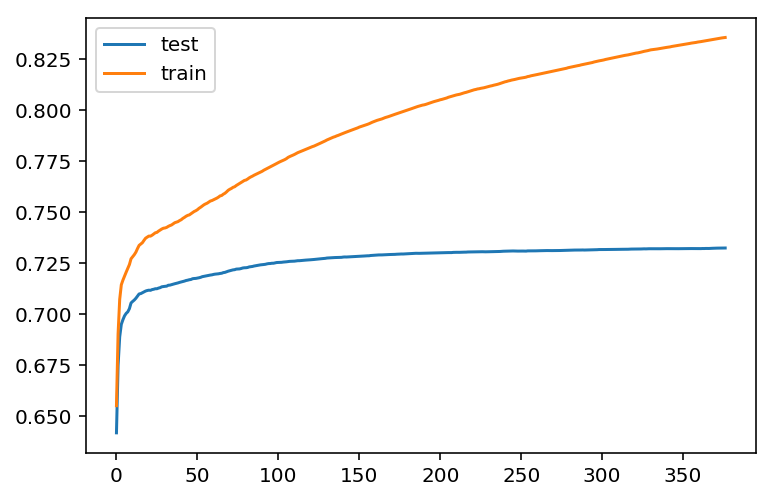

In [160]:
plt.plot(range(xgb_cv.shape[0]), xgb_cv['test-auc-mean'], label='test')
plt.plot(range(xgb_cv.shape[0]), xgb_cv['train-auc-mean'], label='train')
plt.legend();

In [162]:
best_num_round = np.argmax(xgb_cv['test-auc-mean'])
best_num_round

376

In [163]:
X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.9, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((89994, 447), (10000, 447), (89994,), (10000,))

In [164]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid)
dfull = xgb.DMatrix(X, y)
dtest = xgb.DMatrix(X_test)

In [165]:
%%time
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)
print(roc_auc_score(y_valid, bestXgb.predict(dvalid).reshape(-1,1)))

0.7430308890264026
CPU times: user 13min 56s, sys: 265 ms, total: 13min 57s
Wall time: 1min 44s


In [166]:
fullXGB = xgb.train(best_params, dfull, num_boost_round=best_num_round)
final_pred = fullXGB.predict(dtest)

In [ ]:
_xgb_grid_params_iteration2 = {
    'n_estimators': np.linspace(100, 1000, 10, dtype='int'),
#     'learning_rate': np.arange(0.005, 0.1, 0.005)
}

In [ ]:
%%capture In32
%%time

xgb_search2 = GridSearchCV(xgbest1, _xgb_grid_params_iteration2,
                                cv=skf, scoring='roc_auc', 
                                n_jobs=-1, verbose=1)
xgb_search2.fit(X_train, y_train)

In [46]:
In32.show()

Fitting 5 folds for each of 190 candidates, totalling 950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 464.3min


In [ ]:
%%capture In33
xgbest2 = xgb_search2.best_estimator_
xgb_best_complexity = xgb_search2.best_params_
xgb_search2.best_score_, xgb_search2.best_params_

In [ ]:
%%capture In34
print(f"""ROC-AUC on the validation data: 
{roc_auc_score(y_valid, xgbest2.predict_proba(X_valid)[:, 1]):.5f}""")

## SUBMIT

### Last check

In [ ]:
X.shape, X_test.shape, y.shape

In [ ]:
final_estimator = xgbest2
final_estimator

In [ ]:
%%capture In37
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_set=0.9, 
                                                      random_state=42)

_cv_score = cross_val_score(final_estimator, X, y, scoring='roc_auc', cv=skf,
                            n_jobs=-1)

final_estimator.fit(X_train, y_train)
_roc_auc = roc_auc_score(y_valid, final_estimator.predic_proba(X_valid)[:, 1])

print(f'CV: {_cv_score:.5f} \n ROC-AUC: {_roc_auc}')

### Train on the full dataset

In [ ]:
%%capture In38
%%time
final_estimator.fit(X, y)
final_pred = final_estimator.predict_proba(X_test)[: 1]

### Write submission

In [169]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file, 
                             target='dep_delayed_15min', index_label="id"):
    
    predicted_df = pd.DataFrame(
        predicted_labels,
        index = np.arange(0, predicted_labels.shape[0]),
        columns=[target])
    
    predicted_df.to_csv(out_file, index_label=index_label)

In [175]:
!git describe --always

add3ebe


In [174]:
subprocess.check_output(["git", "describe", "--always"]).strip().decode("utf-8")

OSError: [Errno 12] Cannot allocate memory

In [172]:
from datetime import datetime as dt
import subprocess
now = dt.now().strftime("%Y-%m-%d_%H-%M-%S")
label = subprocess.check_output(["git", "describe", "--always"]).strip().decode("utf-8")

### WRITE SUBMISSION
# write_to_submission_file(final_pred, f'../submissions/xgb_submission_at_{now}__githash_{label}.csv')